In [1]:
#@markdown 下載 mnist 資料集


from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
(x_train, _ ), (x_test, _ ) = mnist.load_data()
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

latent_dim = 100


11501568/11490434 [==============================] - 0s 0us/step


In [2]:
#@markdown 建立 Discriminator
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape)) # (28,28,1)
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

In [3]:
#@markdown 建立 Generator
import numpy as np
def build_generator():

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim)) # Noise : 100 -> 256
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(512)) # 256 -> 512
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(1024)) # 512 -> 1024
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    model.add(Dense(np.prod(img_shape), activation='tanh')) # 1024 -> 784(28 * 28)
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)
generator = build_generator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [4]:
#@markdown 合併模型
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [5]:
#@markdown 模型訓練 
from matplotlib import pyplot as plt
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/images/%d.png" % epoch)
    plt.close()


def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

! mkdir -p images
train(100, batch_size=128, sample_interval=50)

0 [D loss: 1.009383, acc.: 33.59%] [G loss: 0.887120]
1 [D loss: 0.392441, acc.: 98.05%] [G loss: 0.859231]
2 [D loss: 0.285669, acc.: 100.00%] [G loss: 0.820460]
3 [D loss: 0.243812, acc.: 100.00%] [G loss: 0.809079]
4 [D loss: 0.211200, acc.: 100.00%] [G loss: 0.761193]
5 [D loss: 0.194744, acc.: 100.00%] [G loss: 0.762207]
6 [D loss: 0.175779, acc.: 100.00%] [G loss: 0.729167]
7 [D loss: 0.163766, acc.: 100.00%] [G loss: 0.703949]
8 [D loss: 0.158668, acc.: 100.00%] [G loss: 0.656743]
9 [D loss: 0.156205, acc.: 100.00%] [G loss: 0.647856]
10 [D loss: 0.156333, acc.: 100.00%] [G loss: 0.657652]
11 [D loss: 0.144244, acc.: 100.00%] [G loss: 0.659602]
12 [D loss: 0.145239, acc.: 100.00%] [G loss: 0.676754]
13 [D loss: 0.152088, acc.: 100.00%] [G loss: 0.688408]
14 [D loss: 0.163287, acc.: 100.00%] [G loss: 0.669074]
15 [D loss: 0.161134, acc.: 100.00%] [G loss: 0.679616]
16 [D loss: 0.158633, acc.: 100.00%] [G loss: 0.709030]
17 [D loss: 0.163302, acc.: 100.00%] [G loss: 0.785543]
18 [

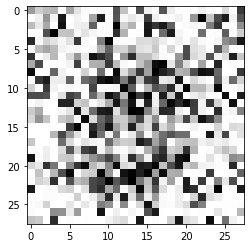

In [6]:
#@markdown 隨機產生圖片
n1 = np.random.normal(0, 1, (1, 100))
gen_imgs = generator.predict(n1)
gen_imgs = 0.5 * gen_imgs + 0.5
plt.imshow(gen_imgs[0, :,:,0], cmap='gray')